In [12]:
import pandas as pd
import numpy as np
from itertools import combinations
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import contextily as ctx

ruta_base = ''
ruta_archivo = ruta_base + 'df_onehot.parquet'  
#ruta_archivo = ruta_base + 'dataset_combinado_final.parquet'  

df = pd.read_parquet(ruta_archivo)

vore diferencies entre cap de setmana, eestacions, festius, en el grafo predeir tots els L

In [13]:
df

,LONGITUD,LATITUD,ALTITUD,periodo_D,periodo_N,time,LAeq,L1,L10,L50,L90,L99
0,-3.777830,40.375250,678,0,1,2014-01-01 00:00:00,68.9,75.8,69.5,57.9,43.3,39.7
1,-3.777830,40.375250,678,1,0,2014-01-01 12:00:00,66.6,75.5,71.2,59.8,46.8,44.1
2,-3.777830,40.375250,678,0,1,2014-01-02 00:00:00,61.1,73.3,64.4,50.3,43.4,41.0
3,-3.777830,40.375250,678,1,0,2014-01-02 12:00:00,69.8,76.7,74.0,67.0,57.4,52.0
4,-3.777830,40.375250,678,0,1,2014-01-03 00:00:00,61.1,72.6,64.8,52.4,46.3,43.4
...,...,...,...,...,...,...,...,...,...,...,...,...
240927,-3.580101,40.476929,627,1,0,2024-08-23 12:00:00,65.2,77.9,64.7,51.9,44.5,42.1
240928,-3.580101,40.476929,627,0,1,2024-08-24 00:00:00,53.6,65.1,55.8,46.5,38.8,35.6
240929,-3.580101,40.476929,627,1,0,2024-08-24 12:00:00,57.3,68.4,60.6,48.8,43.6,41.1
240930,-3.580101,40.476929,627,0,1,2024-08-25 00:00:00,53.9,65.1,56.2,49.1,41.5,38.2


In [14]:
import requests

api_key = ''
years = range(2014, 2024)  # 10 años

all_holidays = {}

for year in years:
    url = f'https://calendarific.com/api/v2/holidays?&api_key={api_key}&country=ES&year={year}&location=MD'
    response = requests.get(url)
    data = response.json()

    holidays = data['response']['holidays']
    all_holidays[year] = [(holiday['name'], holiday['date']['iso']) for holiday in holidays]

# Imprimir los días festivos recopilados
for year, holidays in all_holidays.items():
    print(f"Año {year}:")
    for holiday in holidays:
        print(f"  {holiday[0]}: {holiday[1]}")


Año 2014:
  New Year's Day: 2014-01-01
  Reconquest Day: 2014-01-02
  Epiphany: 2014-01-06
  Valentine's Day: 2014-02-14
  Carnival Monday: 2014-03-03
  Carnival Tuesday: 2014-03-04
  Ash Wednesday: 2014-03-05
  Fathers' Day: 2014-03-19
  San Jose: 2014-03-19
  March Equinox: 2014-03-20T17:57:07+01:00
  Daylight Saving Time starts: 2014-03-30T02:00:00+01:00
  Palm Sunday: 2014-04-13
  Maundy Thursday: 2014-04-17
  Good Friday: 2014-04-18
  Holy Saturday: 2014-04-19
  Easter Sunday: 2014-04-20
  Easter Monday: 2014-04-21
  St George's Day: 2014-04-23
  Labor Day / May Day: 2014-05-01
  Mothers' Day: 2014-05-04
  Whit Sunday/Pentecost: 2014-06-08
  Whit Monday: 2014-06-09
  Corpus Christi: 2014-06-19
  June Solstice: 2014-06-21T12:51:14+02:00
  Saint John the Baptist Day: 2014-06-24
  Feast of Saint James the Apostle: 2014-07-25
  Assumption of Mary: 2014-08-15
  September Equinox: 2014-09-23T04:29:09+02:00
  Hispanic Day: 2014-10-12
  Daylight Saving Time ends: 2014-10-26T03:00:00+02:00

In [15]:
all_holidays

{2014: [("New Year's Day", '2014-01-01'),
  ('Reconquest Day', '2014-01-02'),
  ('Epiphany', '2014-01-06'),
  ("Valentine's Day", '2014-02-14'),
  ('Carnival Monday', '2014-03-03'),
  ('Carnival Tuesday', '2014-03-04'),
  ('Ash Wednesday', '2014-03-05'),
  ("Fathers' Day", '2014-03-19'),
  ('San Jose', '2014-03-19'),
  ('March Equinox', '2014-03-20T17:57:07+01:00'),
  ('Daylight Saving Time starts', '2014-03-30T02:00:00+01:00'),
  ('Palm Sunday', '2014-04-13'),
  ('Maundy Thursday', '2014-04-17'),
  ('Good Friday', '2014-04-18'),
  ('Holy Saturday', '2014-04-19'),
  ('Easter Sunday', '2014-04-20'),
  ('Easter Monday', '2014-04-21'),
  ("St George's Day", '2014-04-23'),
  ('Labor Day / May Day', '2014-05-01'),
  ("Mothers' Day", '2014-05-04'),
  ('Whit Sunday/Pentecost', '2014-06-08'),
  ('Whit Monday', '2014-06-09'),
  ('Corpus Christi', '2014-06-19'),
  ('June Solstice', '2014-06-21T12:51:14+02:00'),
  ('Saint John the Baptist Day', '2014-06-24'),
  ('Feast of Saint James the Apostle'

In [16]:
from datetime import datetime, timedelta

def generate_weekends(start_year, end_year):
    weekends = []
    for year in range(start_year, end_year + 1):
        date = datetime(year, 1, 1)
        while date.year == year:
            if date.weekday() >= 5:  # Sábado (5) y Domingo (6)
                weekends.append(date.strftime('%Y-%m-%d'))
            date += timedelta(days=1)
    return weekends

weekends = generate_weekends(2014, 2024)
print(weekends)  # Muestra los primeros 10 fines de semana encontrados


['2014-01-04', '2014-01-05', '2014-01-11', '2014-01-12', '2014-01-18', '2014-01-19', '2014-01-25', '2014-01-26', '2014-02-01', '2014-02-02', '2014-02-08', '2014-02-09', '2014-02-15', '2014-02-16', '2014-02-22', '2014-02-23', '2014-03-01', '2014-03-02', '2014-03-08', '2014-03-09', '2014-03-15', '2014-03-16', '2014-03-22', '2014-03-23', '2014-03-29', '2014-03-30', '2014-04-05', '2014-04-06', '2014-04-12', '2014-04-13', '2014-04-19', '2014-04-20', '2014-04-26', '2014-04-27', '2014-05-03', '2014-05-04', '2014-05-10', '2014-05-11', '2014-05-17', '2014-05-18', '2014-05-24', '2014-05-25', '2014-05-31', '2014-06-01', '2014-06-07', '2014-06-08', '2014-06-14', '2014-06-15', '2014-06-21', '2014-06-22', '2014-06-28', '2014-06-29', '2014-07-05', '2014-07-06', '2014-07-12', '2014-07-13', '2014-07-19', '2014-07-20', '2014-07-26', '2014-07-27', '2014-08-02', '2014-08-03', '2014-08-09', '2014-08-10', '2014-08-16', '2014-08-17', '2014-08-23', '2014-08-24', '2014-08-30', '2014-08-31', '2014-09-06', '2014

In [17]:
# Suponiendo que ya has cargado los festivos y fines de semana en 'all_holidays' y 'weekends'

# Crear listas con solo las fechas de festivos
holiday_dates = [holiday[1] for year, holidays in all_holidays.items() for holiday in holidays]


# Asegúrate de que la columna 'time' esté en formato datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Extraer la parte del día para la comparación
df['day'] = df['time'].dt.date

# Crear las listas de festivos y fines de semana si aún no están en conjuntos
holiday_dates_set = set(holiday_dates)
weekends_set = set(weekends)

# Actualizar las columnas para festivos y fines de semana con 1 o 0
df['is_holiday'] = df['day'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in holiday_dates_set else 0)
df['is_weekend'] = df['day'].apply(lambda x: 1 if x.strftime('%Y-%m-%d') in weekends_set else 0)

# Mostrar las primeras filas del DataFrame para verificar
print(df.head())


   LONGITUD   LATITUD  ALTITUD  periodo_D  periodo_N                time  \
0  -3.77783  40.37525      678          0          1 2014-01-01 00:00:00   
1  -3.77783  40.37525      678          1          0 2014-01-01 12:00:00   
2  -3.77783  40.37525      678          0          1 2014-01-02 00:00:00   
3  -3.77783  40.37525      678          1          0 2014-01-02 12:00:00   
4  -3.77783  40.37525      678          0          1 2014-01-03 00:00:00   

   LAeq    L1   L10   L50   L90   L99         day  is_holiday  is_weekend  
0  68.9  75.8  69.5  57.9  43.3  39.7  2014-01-01           1           0  
1  66.6  75.5  71.2  59.8  46.8  44.1  2014-01-01           1           0  
2  61.1  73.3  64.4  50.3  43.4  41.0  2014-01-02           1           0  
3  69.8  76.7  74.0  67.0  57.4  52.0  2014-01-02           1           0  
4  61.1  72.6  64.8  52.4  46.3  43.4  2014-01-03           0           0  


In [18]:
df

,LONGITUD,LATITUD,ALTITUD,periodo_D,periodo_N,time,LAeq,L1,L10,L50,L90,L99,day,is_holiday,is_weekend
0,-3.777830,40.375250,678,0,1,2014-01-01 00:00:00,68.9,75.8,69.5,57.9,43.3,39.7,2014-01-01,1,0
1,-3.777830,40.375250,678,1,0,2014-01-01 12:00:00,66.6,75.5,71.2,59.8,46.8,44.1,2014-01-01,1,0
2,-3.777830,40.375250,678,0,1,2014-01-02 00:00:00,61.1,73.3,64.4,50.3,43.4,41.0,2014-01-02,1,0
3,-3.777830,40.375250,678,1,0,2014-01-02 12:00:00,69.8,76.7,74.0,67.0,57.4,52.0,2014-01-02,1,0
4,-3.777830,40.375250,678,0,1,2014-01-03 00:00:00,61.1,72.6,64.8,52.4,46.3,43.4,2014-01-03,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240927,-3.580101,40.476929,627,1,0,2024-08-23 12:00:00,65.2,77.9,64.7,51.9,44.5,42.1,2024-08-23,0,0
240928,-3.580101,40.476929,627,0,1,2024-08-24 00:00:00,53.6,65.1,55.8,46.5,38.8,35.6,2024-08-24,0,1
240929,-3.580101,40.476929,627,1,0,2024-08-24 12:00:00,57.3,68.4,60.6,48.8,43.6,41.1,2024-08-24,0,1
240930,-3.580101,40.476929,627,0,1,2024-08-25 00:00:00,53.9,65.1,56.2,49.1,41.5,38.2,2024-08-25,0,1


In [19]:
df.to_parquet('df_fechas.parquet')

C:\Users\marcs\AppData\Local\Temp\ipykernel_4240\2449417737.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before_covid['period'] = 'Before COVID'
C:\Users\marcs\AppData\Local\Temp\ipykernel_4240\2449417737.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after_covid['period'] = 'After COVID'
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating inst

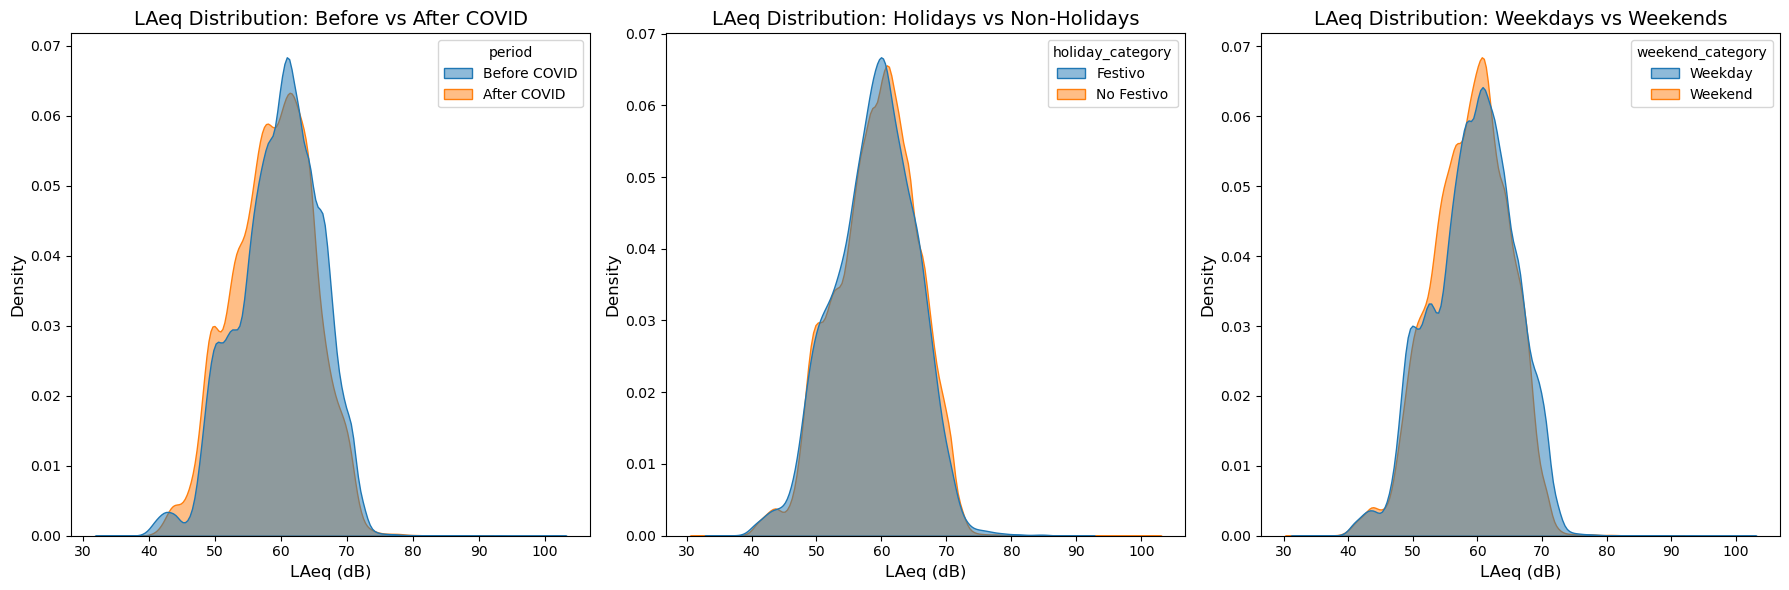

c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


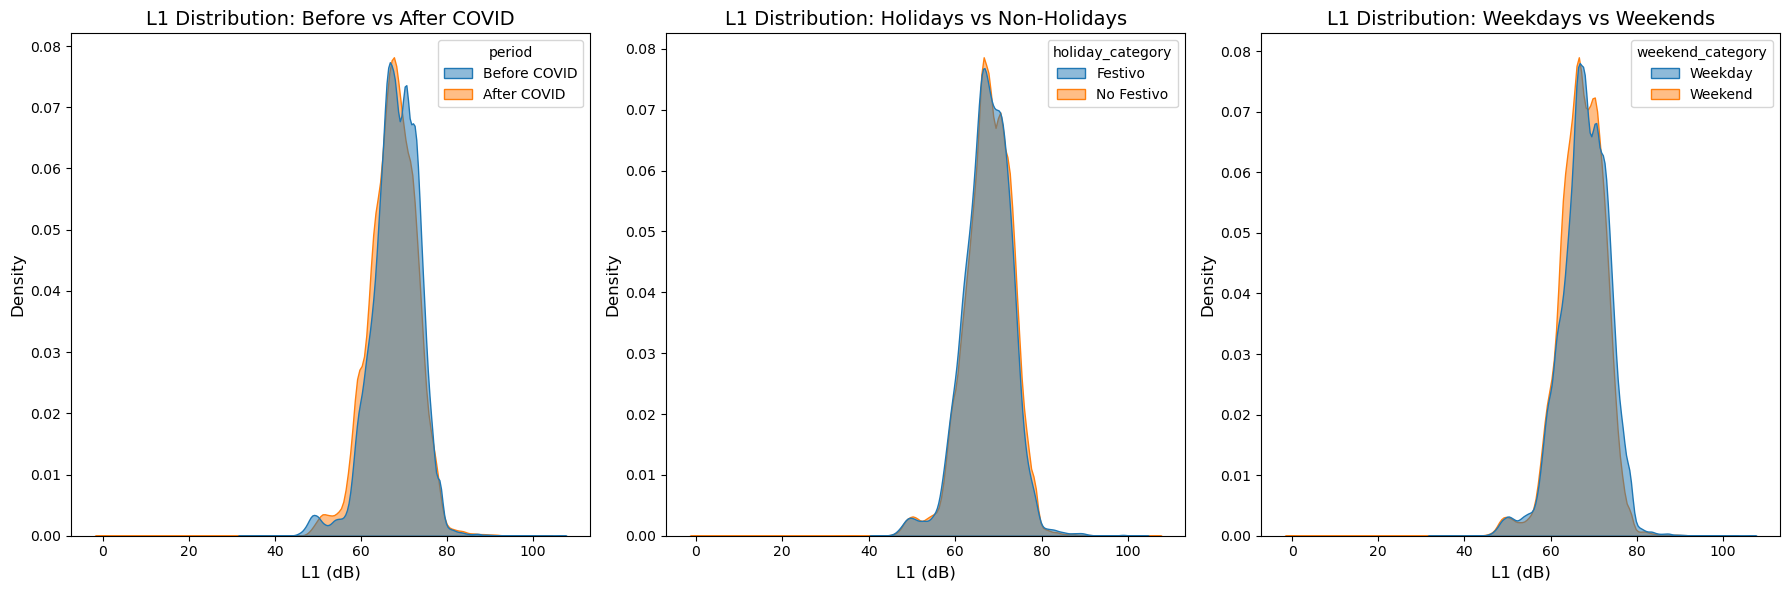

c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


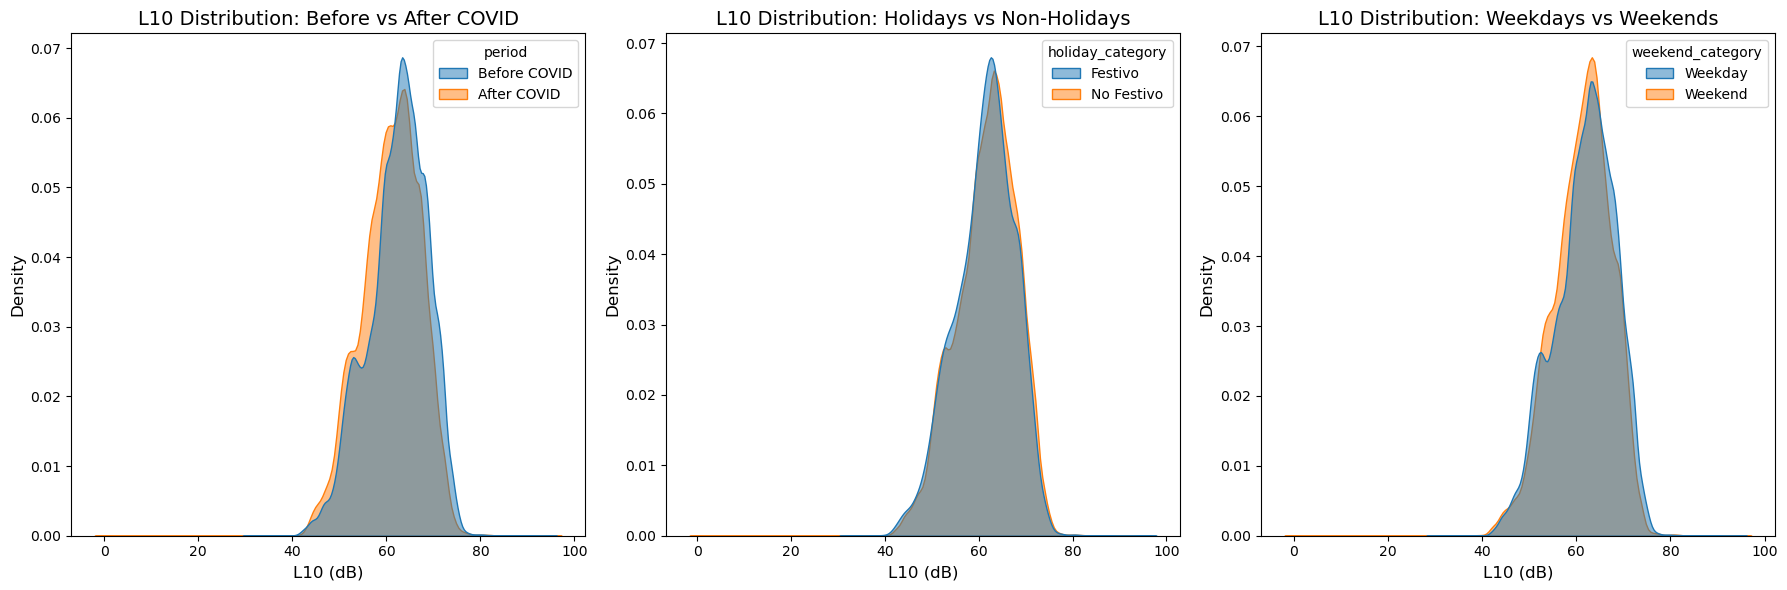

c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


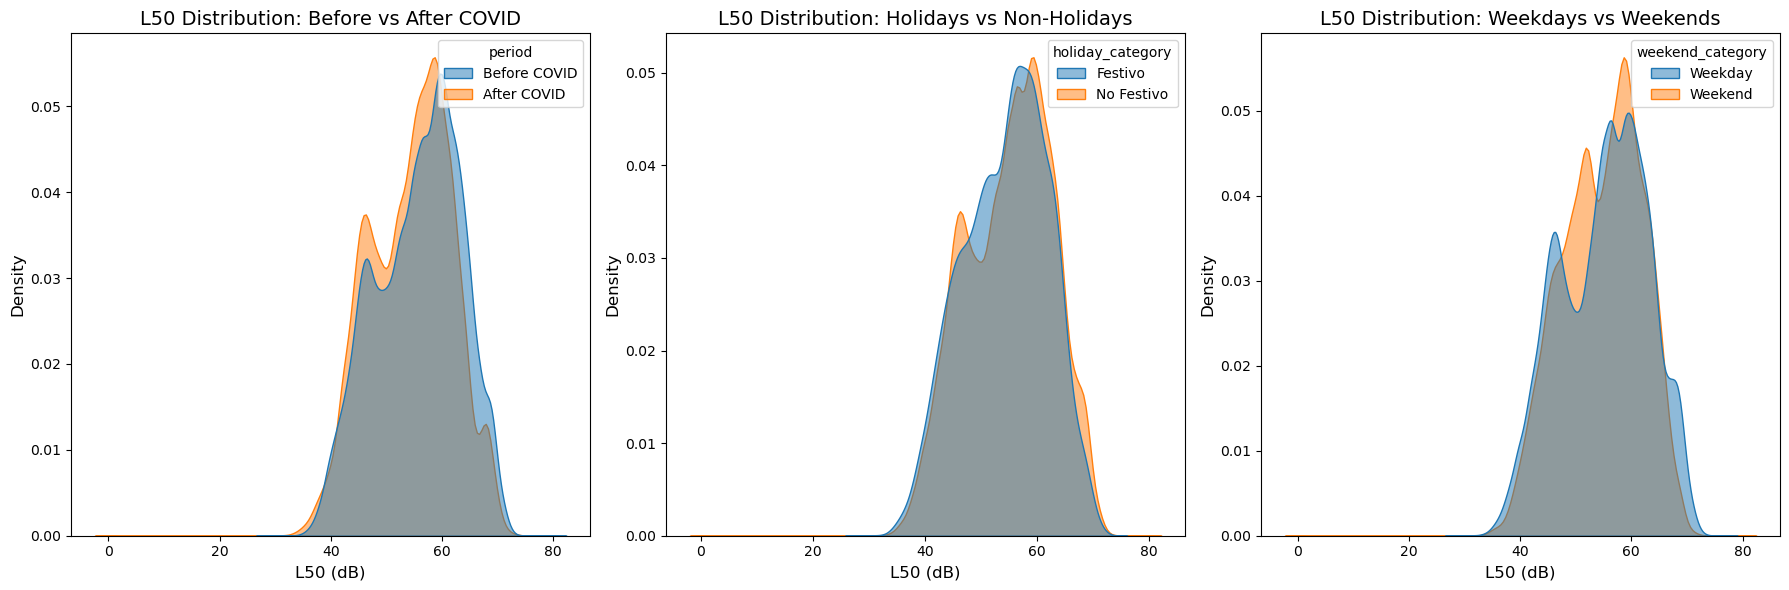

c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


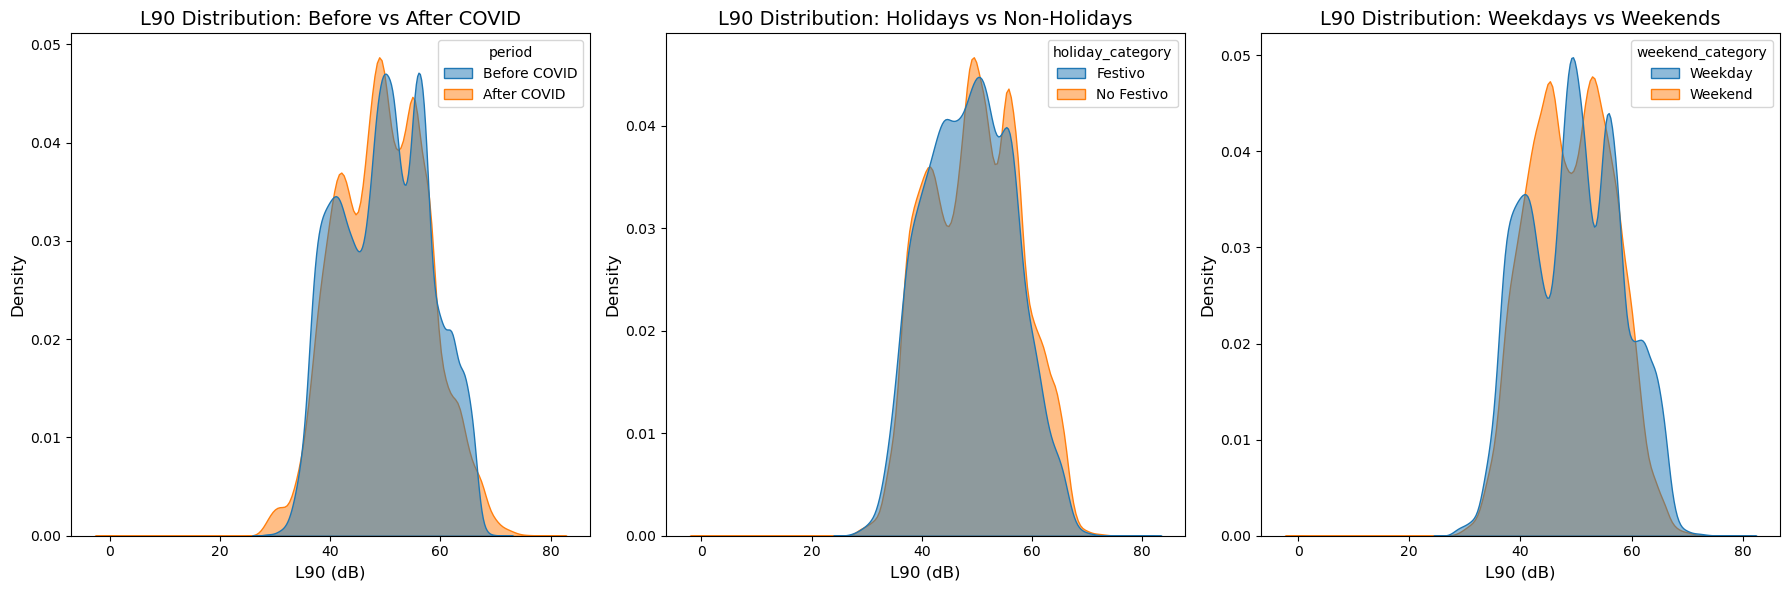

c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


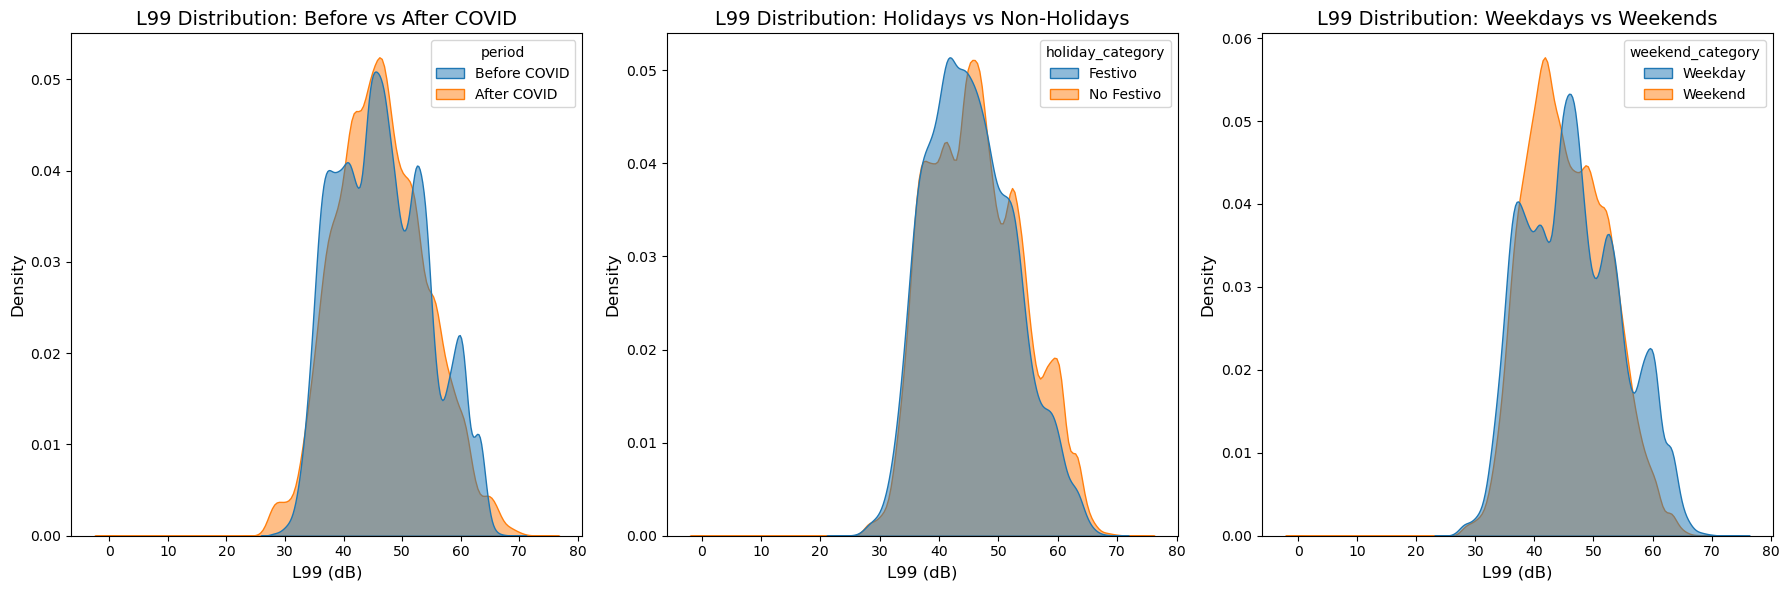

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de variables a graficar
variables = ['LAeq', 'L1', 'L10', 'L50', 'L90', 'L99']
df['holiday_category'] = df['is_holiday'].apply(lambda x: 'Festivo' if x == 1 else 'No Festivo')
df['weekend_category'] = df['is_weekend'].apply(lambda x: 'Weekend' if x == 1 else 'Weekday')

# Filtrar los datos para los períodos antes y después del COVID-19
before_covid = df[(df['time'] < '2020-01-01')]
after_covid = df[(df['time'] >= '2022-01-01')]

# Crear una columna para indicar el período
before_covid['period'] = 'Before COVID'
after_covid['period'] = 'After COVID'

# Concatenar los dos DataFrames
covid_df = pd.concat([before_covid, after_covid])

# Función para crear gráficos de densidad agrupados de 3 en 3 para una variable específica
def plot_density_comparison_for_variable(variable):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gráfico 1: Antes vs Después del COVID
    sns.kdeplot(data=covid_df, x=variable, hue='period', fill=True, common_norm=False, ax=axes[0], alpha=0.5)
    axes[0].set_title(f'{variable} Distribution: Before vs After COVID', fontsize=14)
    axes[0].set_xlabel(f'{variable} (dB)', fontsize=12)
    axes[0].set_ylabel('Density', fontsize=12)
    
    # Gráfico 2: Festivos vs No Festivos
    sns.kdeplot(data=df, x=variable, hue='holiday_category', fill=True, common_norm=False, ax=axes[1], alpha=0.5)
    axes[1].set_title(f'{variable} Distribution: Holidays vs Non-Holidays', fontsize=14)
    axes[1].set_xlabel(f'{variable} (dB)', fontsize=12)
    axes[1].set_ylabel('Density', fontsize=12)
    
    # Gráfico 3: Días entre semana vs Fines de semana
    sns.kdeplot(data=df, x=variable, hue='weekend_category', fill=True, common_norm=False, ax=axes[2], alpha=0.5)
    axes[2].set_title(f'{variable} Distribution: Weekdays vs Weekends', fontsize=14)
    axes[2].set_xlabel(f'{variable} (dB)', fontsize=12)
    axes[2].set_ylabel('Density', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Iterar sobre las variables y generar los gráficos
for var in variables:
    plot_density_comparison_for_variable(var)


c:\Users\marcs\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


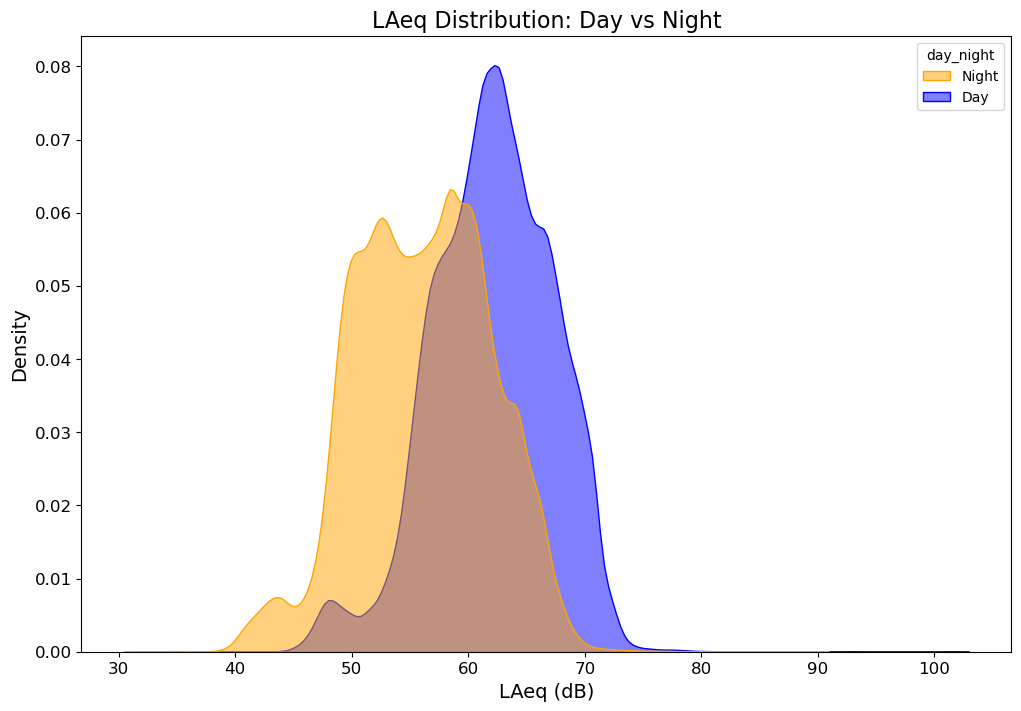

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una columna que identifique "Day" y "Night" usando la columna 'periodo_D'
df['day_night'] = df['periodo_D'].apply(lambda x: 'Day' if x == 1 else 'Night')

# Crear el gráfico de densidad para LAeq durante el día y la noche
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='LAeq', hue='day_night', fill=True, common_norm=False, palette=['orange', 'blue'], alpha=0.5)

# Personalizar el gráfico
plt.title('LAeq Distribution: Day vs Night', fontsize=16)
plt.xlabel('LAeq (dB)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()


In [22]:
import pandas as pd

# Paso 1: Obtener coordenadas únicas y tiempos únicos
coords = df[['LATITUD', 'LONGITUD']].drop_duplicates()
times = df['time'].unique()

# Paso 2: Crear todas las combinaciones posibles de coordenadas y tiempos
coords['key'] = 1
times_df = pd.DataFrame({'time': times})
times_df['key'] = 1
full_df = coords.merge(times_df, on='key').drop('key', axis=1)

# Paso 3: Fusionar con df_complete para identificar registros faltantes
df_full = full_df.merge(df, on=['LATITUD', 'LONGITUD', 'time'], how='left', indicator=True)

# Paso 4: Identificar registros faltantes
missing_entries = df_full[df_full['_merge'] == 'left_only']
num_missing = len(missing_entries)
print(f"Hay {num_missing} combinaciones de coordenadas y time sin datos en df_complete.")

# Paso 5: Analizar los resultados
if num_missing == 0:
    print("Todas las coordenadas tienen datos para todos los tiempos.")
else:
    print("Las siguientes combinaciones de coordenadas y tiempos no tienen datos:")
    print(missing_entries[['LATITUD', 'LONGITUD', 'time']])


Hay 0 combinaciones de coordenadas y time sin datos en df_complete.
Todas las coordenadas tienen datos para todos los tiempos.
